In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import glob

In [ ]:
results_dir = ""
fe_atom_id = 1292
o_atom_id = 3281
output_file = "fe_o_distances.csv"

def parse_dump_file(file_path):
    """Parse LAMMPS dump file and return coordinates of target atoms."""
    fe_coords = None
    o_coords = None
    timestep = None

    with open(file_path, 'r') as f:
        lines = f.readlines()
        
    # Find timestep and atom data
    for i, line in enumerate(lines):
        if "ITEM: TIMESTEP" in line:
            timestep = int(lines[i+1].strip())
        if "ITEM: ATOMS" in line:
            headers = line.split()[2:]  # Get column headers (id, type, x, y, z, etc.)
            data_start = i + 1
            break

    id_idx = headers.index("id")
    x_idx = headers.index("x")
    y_idx = headers.index("y")
    z_idx = headers.index("z")

    # Parse atom data
    for line in lines[data_start:]:
        values = line.split()
        atom_id = int(values[id_idx])
        
        if atom_id == fe_atom_id:
            fe_coords = np.array([float(values[x_idx]), 
                                float(values[y_idx]), 
                                float(values[z_idx])])
        elif atom_id == o_atom_id:
            o_coords = np.array([float(values[x_idx]), 
                                float(values[y_idx]), 
                                float(values[z_idx])])
    
    return timestep, fe_coords, o_coords

In [ ]:
def combine_distances():
    sim_dirs = glob.glob("simulation_results_*")
    sim_dirs.sort(key=lambda x: int(x.split('_')[-1]))
    
    all_distances = []
    for sim_dir in sim_dirs:
        # Collect and sort dump files by timestep
        dump_files = [f for f in os.listdir(sim_dir) if f.startswith("dmp.") and f.endswith(".txt")]
        dump_files.sort(key=lambda x: int(x.split('.')[1]))  # Sort by timestep
        
        distances = []
        for dump_file in dump_files:
            file_path = os.path.join(sim_dir, dump_file)
            timestep, fe_coords, o_coords = parse_dump_file(file_path)
            
            if fe_coords is None or o_coords is None:
                print(f"Warning: Missing atoms in {file_path}, timestep {timestep}")
                continue
                
            distance = np.linalg.norm(o_coords - fe_coords)
            distances.append(distance)
        
        if len(distances) == 0:
            print(f"Warning: No valid distances found in directory {sim_dir}")
            continue
        all_distances.append(distances)
    
    min_len = min(len(dist) for dist in all_distances)
    all_distances = [dist[:min_len] for dist in all_distances]

    distance_array = np.array(all_distances)
    return distance_array

In [15]:
distances = combine_distances()

In [16]:
distances.shape

(6, 504)

In [ ]:
def read_energy_data(filename):
    energy_values = []
    
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue

            parts = line.split()
            if len(parts) >= 2:
                try:
                    energy = float(parts[1])
                    energy_values.append(energy)
                except ValueError:
                    continue
                    
    return energy_values

def process_directories_energy(directories):
    ke_data_list = []
    pe_data_list = []

    for results_dir in directories:
        ke_file = results_dir + '/ke_data.txt'
        pe_file = results_dir + '/pe_data.txt'

        ke_data = read_energy_data(ke_file)
        pe_data = read_energy_data(pe_file)

        ke_data_list.append(ke_data)
        pe_data_list.append(pe_data)

    min_len = min(len(ke_data) for ke_data in ke_data_list)
    ke_data_list = [ke_data[:min_len] for ke_data in ke_data_list]

    min_len = min(len(pe_data) for pe_data in pe_data_list)
    pe_data_list = [pe_data[:min_len] for pe_data in pe_data_list]

    ke_data_array = np.array(ke_data_list)
    pe_data_array = np.array(pe_data_list)

    return ke_data_array, pe_data_array

In [8]:
list_dir = ['simulation_results_1', 'simulation_results_2', 'simulation_results_3',
            'simulation_results_4', 'simulation_results_5', 'simulation_results_6']
ke_data, pe_data = process_directories_energy(list_dir)

In [9]:
ke_data.shape, pe_data.shape

((6, 500), (6, 500))

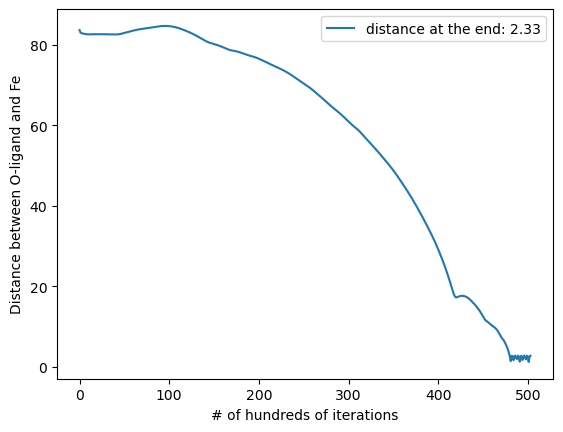

In [27]:
cur = distances[5, :]
plt.plot(cur, label=f"distance at the end: {np.mean(cur[-10:]):.2f}")
plt.legend()
plt.ylabel('Distance between O-ligand and Fe')
plt.xlabel('# of hundreds of iterations')
plt.show()

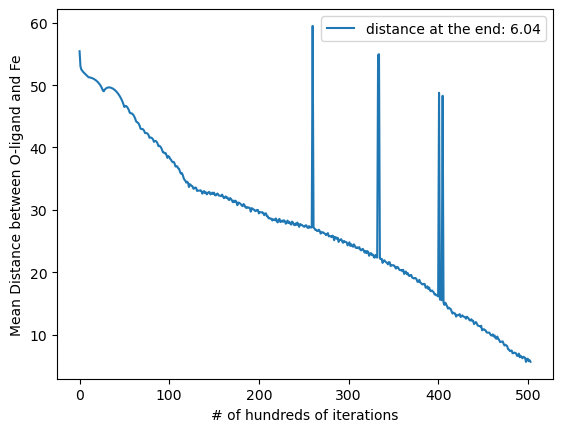

In [17]:
mean_dist = np.mean(distances, axis = 0)
plt.plot(mean_dist, label=f"distance at the end: {np.mean(mean_dist[-10:]):.2f}")
plt.legend()
plt.ylabel('Mean Distance between O-ligand and Fe')
plt.xlabel('# of hundreds of iterations')
plt.show()

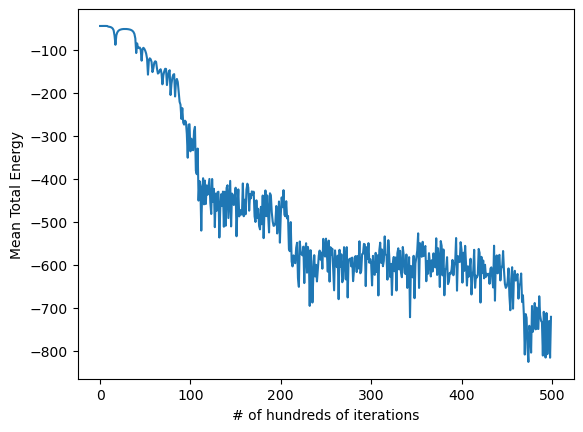

In [11]:
mean_sum_energy = np.mean(pe_data + ke_data, axis=0)
plt.plot(mean_sum_energy)
plt.ylabel('Mean Total Energy')
plt.xlabel('# of hundreds of iterations')
plt.show()

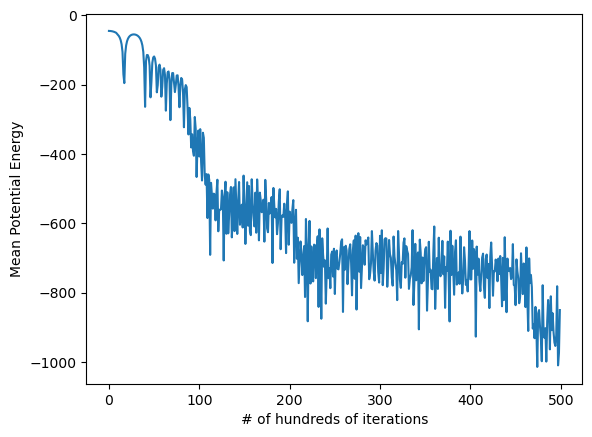

In [6]:
mean_potential = np.mean(pe_data, axis=0)
plt.plot(mean_potential)
plt.ylabel('Mean Potential Energy')
plt.xlabel('# of hundreds of iterations')
plt.show()